# Diabetic Retinopathy - InceptionV3
-----------

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import torch
import torchvision
from torchvision import transforms, models
from torch import nn, optim
import torch.nn.functional as F
import sklearn.metrics as metrics

print("Do you want to run the training process? (y / n)")
i = input()
if i == 'y':
    train_model = True
else:
    train_model = False
    
fpath = "/home/arttu/Documents/research/blindness/"
# fpath = "hakkina7@triton.aalto.fi:/scratch/work/hakkina7/research/blindness/"
print("File path is {}".format(fpath))

# Set the device
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)
print("Device is {}".format(device))

# Set file name
fname = 'inceptionV3.pth'

Do you want to run the training process? (y / n)
n
File path is /home/arttu/Documents/research/blindness/
Device is cpu


## Data preprocessing
--------------

### Important: In contrast to the other models the inception_v3 expects tensors with a size of N x 3 x 299 x 299, so ensure your images are sized accordingly.

Show some images? (y / n)
y
tensor([0, 0, 1, 0, 1])


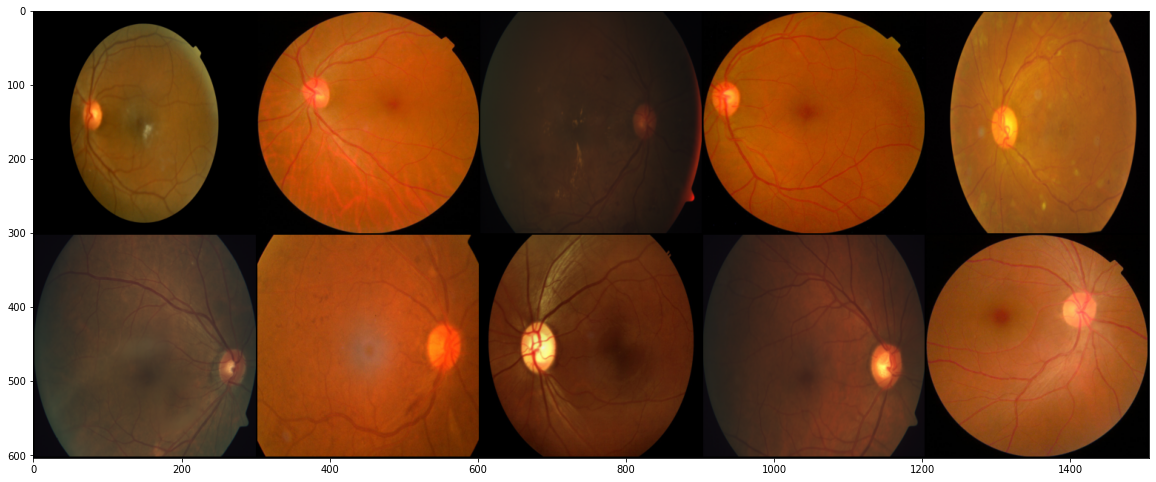

In [12]:
# Takes a while to run the mean and std calculation, so save the values here
# NB: These have to be calculated again if the image size is changed
# NB: Modifying the batch size doesn't matter, mean and std stay the same
# mean = [0.485, 0.456, 0.406] # https://pytorch.org/hub/pytorch_vision_inception_v3/
# std = [0.229, 0.224, 0.225] # https://pytorch.org/hub/pytorch_vision_inception_v3/

h, w = (299, 299)
# Get proper dataloader with normalized images
transformations = transforms.Compose([
    transforms.Resize((h, w)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.0, 0.0, 0.0]), torch.Tensor([1.0, 1.0, 1.0]))
])

trainset = torchvision.datasets.ImageFolder(root=fpath+"data/train/",
                                           transform=transformations)
testset = torchvision.datasets.ImageFolder(root=fpath+"data/test/",
                                           transform=transformations)
valset = torchvision.datasets.ImageFolder(root=fpath+"data/val/",
                                           transform=transformations)

trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=8, shuffle=False)
valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=8, shuffle=False)

print("Show some images? (y / n)")
i = input()
if i == 'y':
    show = True
else:
    show = False

if show:
    # Show some images after transformations
    loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=5, shuffle=True)
    images, labels = next(iter(loader))
    images2, labels2 = next(iter(loader))
    grid=torchvision.utils.make_grid(torch.cat([images, images2], axis=0), nrow=len(images))
    plt.figure(figsize=(20, 40))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.savefig("plotttttt.png")
    print(labels)

## Training
--------------

In [3]:
def train(model, epochs, trainloader, testloader, device, optimizer, loss_fn):
    """Training loop"""
    
    for epoch in range(epochs):
        model.train()
        best_acc = 0
        losses = []
        correct = 0
        total = 0
        start = time.time()
        for i, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(images)
            _, pred = torch.max(outputs, 1)
            correct += (labels == pred).sum().item()
            total += labels.size(0)
            loss = loss_fn(outputs, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            print("Batch {}/{}: {:.2f} seconds".format(i+1, len(trainloader), time.time()-start))
            start=time.time()
        acc = 100 * correct/total
        print("\nEpoch {}:\nMean loss {} - Correctly labeled training images {:.2f}%".format(epoch+1,
                                                                                           np.mean(losses),
                                                                                           acc))
        
        model.eval()
        correct = 0
        total = 0
        true = torch.zeros(0, dtype=torch.long, device='cpu')
        preds = torch.zeros(0, dtype=torch.long, device='cpu')
        probs = torch.zeros(0, dtype=torch.float, device='cpu')
        with torch.no_grad():
            start = time.time()
            for i, (images, labels) in enumerate(testloader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, pred = torch.max(outputs, 1)
                correct += (pred == labels).sum().item()
                total += labels.size(0)
                true = torch.cat([true, labels.view(-1)])
                preds = torch.cat([preds, pred.view(-1)])
                prob, _ = (F.softmax(outputs, dim=1)).topk(1, dim=1)
                probs = torch.cat([probs, prob.view(-1)])
                print("Batch {}/{}: {:.2f} seconds".format(i+1, len(testloader), time.time()-start))
                start=time.time()
                
        acc = 100 * correct/total
        print("Classified {:.2f} % of test images correctly.".format(
            acc
        ))
        print("Precision on test set: {}".format(
            metrics.precision_score(true.numpy(), preds.numpy())
        ))
        print("Recall on test set: {}".format(
            metrics.recall_score(true.numpy(), preds.numpy())
        ))
        print("F1-score on test set: {}".format(
            metrics.f1_score(true.numpy(), preds.numpy())
        ))
        print("AUC score on test set: {}".format(
            metrics.roc_auc_score(true.numpy(), probs.numpy())
        ))
        print("Confusion matrix on test set:")
        print(pd.DataFrame(metrics.confusion_matrix(true.numpy(), preds.numpy()), 
                           columns=['pred as NEG', 'pred as POS'], 
                           index=['true class NEG', 'true class POS']))
        print()

    print("Training finished.")

    return model


if train_model:
    print("Training InceptionV3 model for Diabetic Retinopathy classification task.")
    
    # Initialize the model
    model = models.inception_v3(pretrained=False)
    n_labels = 2
    n_inputs = model.fc.in_features
    model.fc = nn.Linear(n_inputs, n_labels)
    model = model.to(device)
    
    # Calculate weights for the weighted loss function. We need the weighted loss,
    # because of the class imbalance that is present on the data sets. If
    # weighted loss fails, try focal loss with alpha=0.25 and gamma=2.
    n_samples = [1444, 1486]
    weights = [1 / (x / sum(n_samples)) for x in n_samples]  # More weight on the samples that appear less
    weights = torch.FloatTensor(weights).to(device)
    print("Since there is class imbalance present in some of the data sets, use the following weights in the loss function:")
    print(weights)
    print()
    
    # Train model
    model = train(model=model,
                  epochs=100,
                  trainloader=trainloader,
                  testloader=testloader,
                  device=device,
                  optimizer=optim.SGD(list(model.parameters()),
                                      lr=1e-3,
                                      momentum=0.9),
                  loss_fn=nn.CrossEntropyLoss(weight=weights))
    
    # Save the trained model
    torch.save(model.state_dict(), fpath+fname)
    print("Model succesfully saved to {}".format(fpath+fname))

Training InceptionV3 model for Diabetic Retinopathy classification task.


/home/arttu/miniconda3/envs/leanheat/lib/python3.6/site-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


Since there is class imbalance present in some of the data sets, use the following weights in the loss function:
tensor([0.5072, 0.4928])
Batch 1/23: 3.42 seconds
Batch 2/23: 3.64 seconds
Batch 3/23: 3.23 seconds
Batch 4/23: 3.32 seconds
Batch 5/23: 3.45 seconds
Batch 6/23: 3.34 seconds
Batch 7/23: 3.34 seconds
Batch 8/23: 3.50 seconds
Batch 9/23: 3.09 seconds
Batch 10/23: 3.39 seconds
Batch 11/23: 3.82 seconds
Batch 12/23: 3.89 seconds
Batch 13/23: 4.08 seconds
Batch 14/23: 4.07 seconds
Batch 15/23: 4.23 seconds
Batch 16/23: 3.99 seconds
Batch 17/23: 3.73 seconds
Batch 18/23: 3.84 seconds
Batch 19/23: 4.36 seconds
Batch 20/23: 4.11 seconds
Batch 21/23: 4.05 seconds
Batch 22/23: 3.90 seconds
Batch 23/23: 2.97 seconds

Epoch 1:
Mean loss 1.1769774162018185 - Correctly labeled training images 68.68%
Batch 1/23: 1.37 seconds
Batch 2/23: 1.87 seconds
Batch 3/23: 1.44 seconds
Batch 4/23: 1.50 seconds
Batch 5/23: 1.44 seconds
Batch 6/23: 1.47 seconds
Batch 7/23: 1.47 seconds
Batch 8/23: 1.34

## Evaluate
---------

/home/arttu/miniconda3/envs/leanheat/lib/python3.6/site-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


Model succesfully loaded from /home/arttu/Documents/research/blindness/inceptionV3.pth
Evaluating the InceptionV3 model on the validation set.
Batch 1/23: 1.36 seconds
Batch 2/23: 1.86 seconds
Batch 3/23: 1.35 seconds
Batch 4/23: 1.49 seconds
Batch 5/23: 1.49 seconds
Batch 6/23: 1.43 seconds
Batch 7/23: 1.47 seconds
Batch 8/23: 1.36 seconds
Batch 9/23: 1.45 seconds
Batch 10/23: 1.60 seconds
Batch 11/23: 1.68 seconds
Batch 12/23: 2.06 seconds
Batch 13/23: 2.23 seconds
Batch 14/23: 2.07 seconds
Batch 15/23: 2.60 seconds
Batch 16/23: 1.78 seconds
Batch 17/23: 1.87 seconds
Batch 18/23: 2.06 seconds
Batch 19/23: 2.35 seconds
Batch 20/23: 2.37 seconds
Batch 21/23: 1.80 seconds
Batch 22/23: 2.06 seconds
Batch 23/23: 1.59 seconds

Classified 50.55 % of validation images correctly.
Precision on validation set: 0.5054945054945055
Recall on validation set: 1.0
F1-score on validation set: 0.6715328467153284
AUC score on validation set: 0.5637681159420289 or 0.5637681159420289
Confusion matrix on v

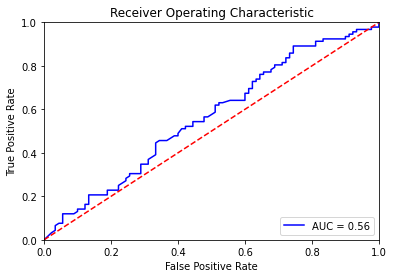

In [4]:
def evaluate(model, valloader, device):
    """Evaluate model performance on validation set"""
    
    model.eval()
    correct = 0
    total = 0
    true = torch.zeros(0, dtype=torch.long, device='cpu')
    preds = torch.zeros(0, dtype=torch.long, device='cpu')
    probs = torch.zeros(0, dtype=torch.float, device='cpu')
    with torch.no_grad():
        start = time.time()
        for i, (images, labels) in enumerate(valloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred = torch.max(outputs, 1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
            true = torch.cat([true, labels.view(-1)])
            preds = torch.cat([preds, pred.view(-1)])
            prob, _ = (F.softmax(outputs, dim=1)).topk(1, dim=1)
            probs = torch.cat([probs, prob.view(-1)])
            print("Batch {}/{}: {:.2f} seconds".format(i+1, len(valloader), time.time()-start))
            start=time.time()
    
    acc = 100 * correct/total
    print("\nClassified {:.2f} % of validation images correctly.".format(
            acc
        ))
    print("Precision on validation set: {}".format(
        metrics.precision_score(true.numpy(), preds.numpy())
    ))
    print("Recall on validation set: {}".format(
        metrics.recall_score(true.numpy(), preds.numpy())
    ))
    print("F1-score on validation set: {}".format(
        metrics.f1_score(true.numpy(), preds.numpy())
    ))
    fpr, tpr, threshold = metrics.roc_curve(true.numpy(), probs.numpy())
    print("AUC score on validation set: {} or {}".format(
        metrics.roc_auc_score(true.numpy(), probs.numpy()),
        metrics.auc(fpr, tpr)
    ))
    print("Confusion matrix on validation set:")
    print(pd.DataFrame(metrics.confusion_matrix(true.numpy(), preds.numpy()), 
                       columns=['pred as NEG', 'pred as POS'], 
                       index=['true class NEG', 'true class POS']))
    print()
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % metrics.auc(fpr, tpr))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    print()
    

# Initialize model
model = models.inception_v3(pretrained=False)
n_labels = 2
n_inputs = model.fc.in_features
model.fc = nn.Linear(n_inputs, n_labels)

# Load model params
if torch.cuda.is_available():
    model.load_state_dict(torch.load(fpath+fname))
    model.to(device)
else:
    model.load_state_dict(torch.load(fpath+fname,
                                     map_location=torch.device('cpu')))
    
print("Model succesfully loaded from {}".format(fpath+fname))

# Evaluate the model performance on validation set
print("Evaluating the InceptionV3 model on the validation set.")
evaluate(model, valloader, device)